# BAF660 빅데이터와 금융자료분석 - 기말대체과제 EDA (prob2_card.csv)

이 노트북에서는 신용카드 고객 데이터(`prob2_card.csv`)에 대한 
탐색적 데이터 분석(EDA)을 수행합니다.

## 1. 데이터 로드 및 기본 정보 확인

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import os # 파일 경로 처리를 위해 os 모듈 추가
from mpl_toolkits.mplot3d import Axes3D # 3D 시각화 위해 추가

# 시각화 설정
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# 플롯 저장 디렉토리 생성
plot_dir_eda2 = 'plots/eda2'
os.makedirs(plot_dir_eda2, exist_ok=True)

# 데이터 로드
card_data = pd.read_csv('prob2_card.csv')

# 데이터 기본 정보 확인
print("--- Credit Card 데이터셋 ---")
print("데이터셋 형태:", card_data.shape)

--- Credit Card 데이터셋 ---
데이터셋 형태: (8950, 6)


In [2]:

print("\n데이터셋 정보:")
print(card_data.info())


데이터셋 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CUST_ID              8950 non-null   object 
 1   BALANCE              8950 non-null   float64
 2   BALANCE_FREQUENCY    8950 non-null   float64
 3   PURCHASES            8950 non-null   float64
 4   PURCHASES_FREQUENCY  8950 non-null   float64
 5   PURCHASES_TRX        8950 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 419.7+ KB
None


In [3]:

print("\n데이터셋 통계 요약:")
print(card_data.describe())


데이터셋 통계 요약:
            BALANCE  BALANCE_FREQUENCY     PURCHASES  PURCHASES_FREQUENCY  \
count   8950.000000        8950.000000   8950.000000          8950.000000   
mean    1564.474828           0.877271   1003.204834             0.490351   
std     2081.531879           0.236904   2136.634782             0.401371   
min        0.000000           0.000000      0.000000             0.000000   
25%      128.281915           0.888889     39.635000             0.083333   
50%      873.385231           1.000000    361.280000             0.500000   
75%     2054.140036           1.000000   1110.130000             0.916667   
max    19043.138560           1.000000  49039.570000             1.000000   

       PURCHASES_TRX  
count    8950.000000  
mean       14.709832  
std        24.857649  
min         0.000000  
25%         1.000000  
50%         7.000000  
75%        17.000000  
max       358.000000  


In [4]:
# 상위 5개 행 확인
print("\n데이터셋 상위 5개 행:")
print(card_data.head())


데이터셋 상위 5개 행:
  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  PURCHASES_FREQUENCY  \
0  C10001    40.900749           0.818182      95.40             0.166667   
1  C10002  3202.467416           0.909091       0.00             0.000000   
2  C10003  2495.148862           1.000000     773.17             1.000000   
3  C10004  1666.670542           0.636364    1499.00             0.083333   
4  C10005   817.714335           1.000000      16.00             0.083333   

   PURCHASES_TRX  
0              2  
1              0  
2             12  
3              1  
4              1  


## 2. 결측치 분석

In [5]:
# CUST_ID는 식별자이므로 분석에서 제외하기 전에 결측치 확인
print("\nCUST_ID 결측치 확인:", card_data['CUST_ID'].isnull().sum())

# CUST_ID를 인덱스로 설정 (고유 식별자 처리)
if 'CUST_ID' in card_data.columns:
    if card_data['CUST_ID'].nunique() == len(card_data):
        print("\nCUST_ID를 인덱스로 설정합니다.")
        card_data.set_index('CUST_ID', inplace=True)
    else:
        print("\n경고: CUST_ID가 고유하지 않아 인덱스로 설정하지 않습니다.")

# 나머지 변수들의 결측치 확인
missing_values_card = card_data.isnull().sum()
missing_percent_card = card_data.isnull().mean() * 100

missing_df_card = pd.DataFrame({
    '결측치 수': missing_values_card,
    '결측치 비율(%)': missing_percent_card
})

print("\n결측치 분석 (CUST_ID 제외):")
print(missing_df_card[missing_df_card['결측치 수'] > 0])

if missing_df_card['결측치 수'].sum() == 0:
    print("분석 대상 변수에 결측치가 없습니다.") 


CUST_ID 결측치 확인: 0

CUST_ID를 인덱스로 설정합니다.

결측치 분석 (CUST_ID 제외):
Empty DataFrame
Columns: [결측치 수, 결측치 비율(%)]
Index: []
분석 대상 변수에 결측치가 없습니다.


## 3. 데이터 분포 탐색

In [6]:
# 카드 데이터는 모두 수치형 변수로 구성되어 있습니다.
card_numerical_cols = card_data.columns.tolist()

print("카드 데이터 변수 (모두 수치형):")
print(card_numerical_cols)

카드 데이터 변수 (모두 수치형):
['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'PURCHASES_FREQUENCY', 'PURCHASES_TRX']


In [7]:
# 수치형 변수 기술 통계량 계산
card_numerical_stats = card_data[card_numerical_cols].describe().T
card_numerical_stats['분산'] = card_data[card_numerical_cols].var()
card_numerical_stats['왜도'] = card_data[card_numerical_cols].skew()
card_numerical_stats['첨도'] = card_data[card_numerical_cols].kurtosis()

print("\n카드 데이터 수치형 변수 기술 통계량:")
print(card_numerical_stats)


카드 데이터 수치형 변수 기술 통계량:
                      count         mean          std  min         25%  \
BALANCE              8950.0  1564.474828  2081.531879  0.0  128.281915   
BALANCE_FREQUENCY    8950.0     0.877271     0.236904  0.0    0.888889   
PURCHASES            8950.0  1003.204834  2136.634782  0.0   39.635000   
PURCHASES_FREQUENCY  8950.0     0.490351     0.401371  0.0    0.083333   
PURCHASES_TRX        8950.0    14.709832    24.857649  0.0    1.000000   

                            50%          75%          max            분산  \
BALANCE              873.385231  2054.140036  19043.13856  4.332775e+06   
BALANCE_FREQUENCY      1.000000     1.000000      1.00000  5.612351e-02   
PURCHASES            361.280000  1110.130000  49039.57000  4.565208e+06   
PURCHASES_FREQUENCY    0.500000     0.916667      1.00000  1.610985e-01   
PURCHASES_TRX          7.000000    17.000000    358.00000  6.179027e+02   

                           왜도          첨도  
BALANCE              2.393386    7.67

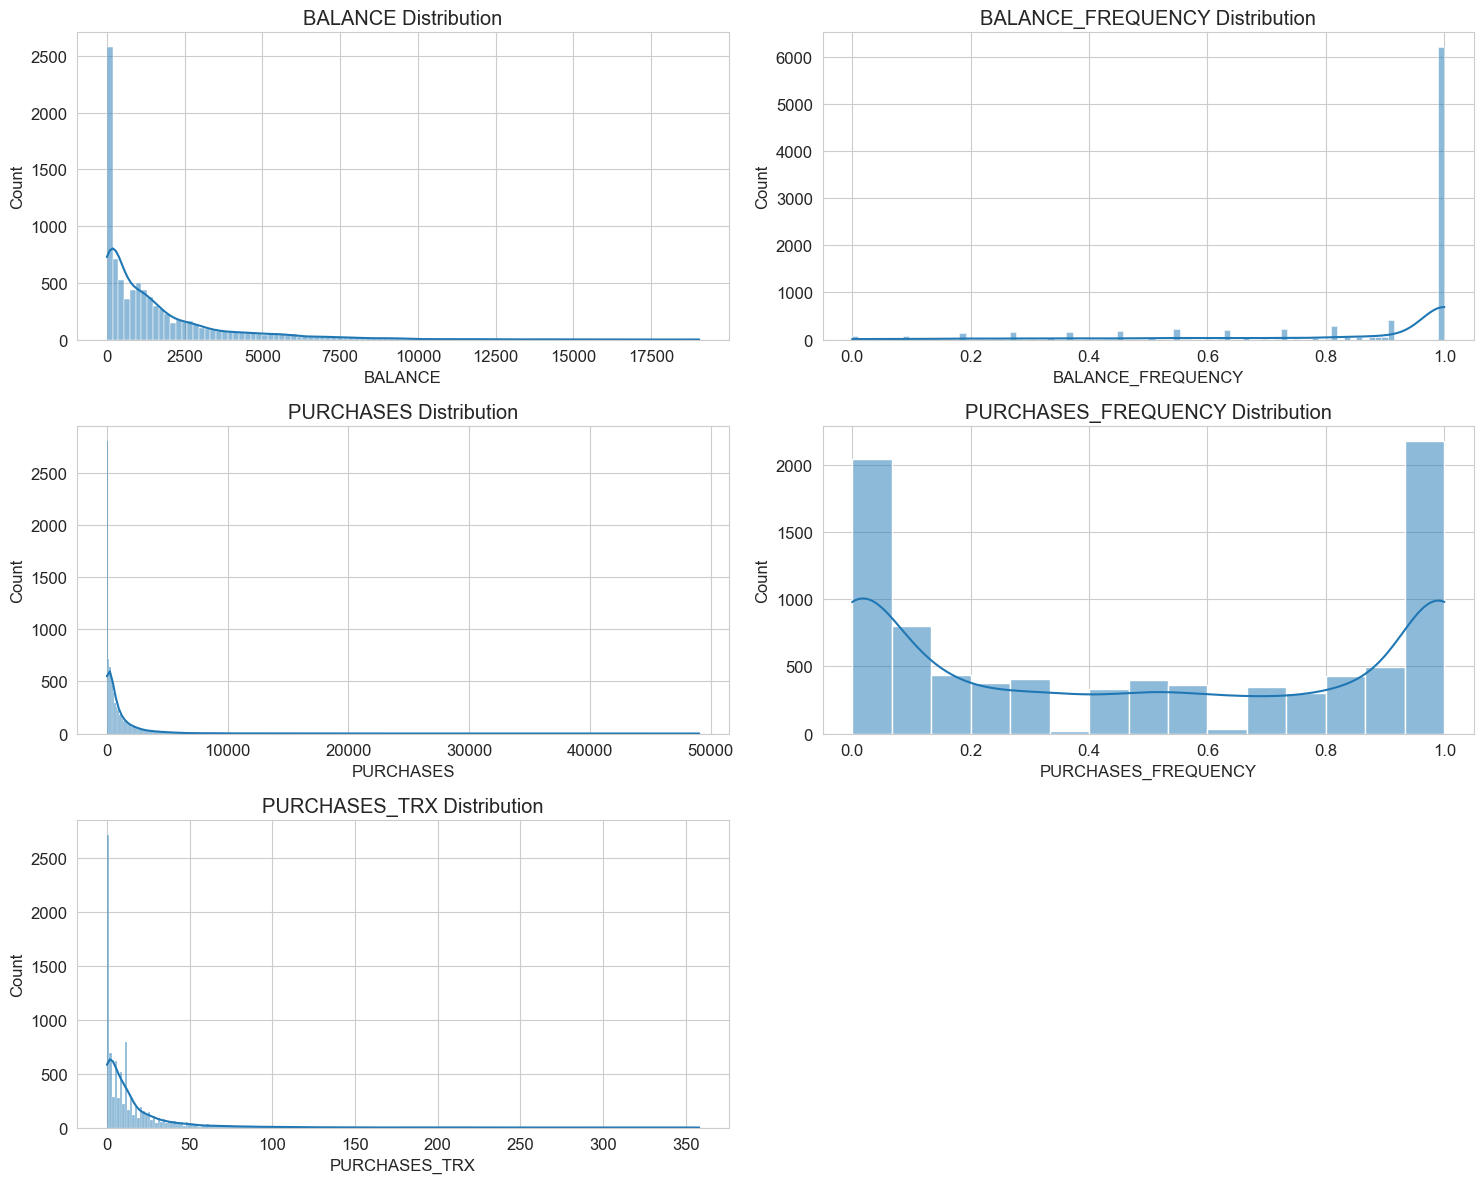

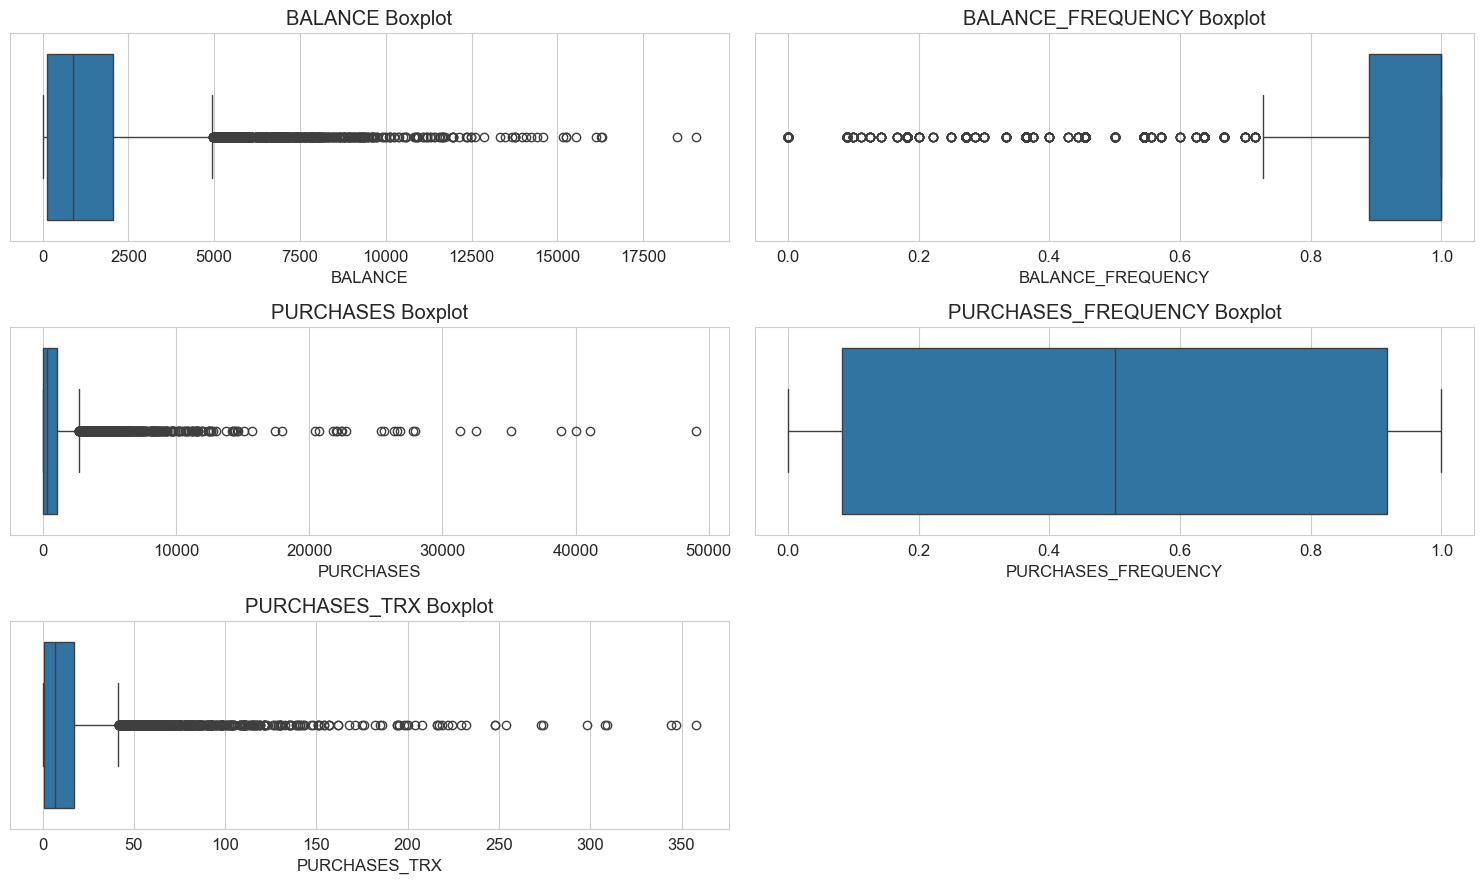

In [8]:
# 수치형 변수 분포 시각화 (히스토그램)
num_plots = len(card_numerical_cols)
num_cols_grid = 2
num_rows_grid = (num_plots + num_cols_grid - 1) // num_cols_grid

fig_hist, axes_hist = plt.subplots(num_rows_grid, num_cols_grid, figsize=(15, num_rows_grid * 4))
axes_hist = axes_hist.flatten() # 축 배열을 1차원으로 만듦

for i, col in enumerate(card_numerical_cols):
    sns.histplot(card_data[col], kde=True, ax=axes_hist[i])
    axes_hist[i].set_title(f'{col} Distribution')
    
# 남는 축 숨기기
for j in range(i + 1, len(axes_hist)):
    fig_hist.delaxes(axes_hist[j])
    
plt.tight_layout()
plot_filename_hist = os.path.join(plot_dir_eda2, 'numerical_distributions_hist.png')
plt.savefig(plot_filename_hist)
plt.show()
plt.close(fig_hist)

# 박스플롯 시각화
fig_box, axes_box = plt.subplots(num_rows_grid, num_cols_grid, figsize=(15, num_rows_grid * 3))
axes_box = axes_box.flatten()

for i, col in enumerate(card_numerical_cols):
    sns.boxplot(x=card_data[col], ax=axes_box[i])
    axes_box[i].set_title(f'{col} Boxplot')

# 남는 축 숨기기
for j in range(i + 1, len(axes_box)):
    fig_box.delaxes(axes_box[j])

plt.tight_layout()
plot_filename_box = os.path.join(plot_dir_eda2, 'numerical_distributions_box.png')
plt.savefig(plot_filename_box)
plt.show()
plt.close(fig_box)

## 4. 이상치 탐지

Ch1_(1).py에서 배운 이상치 탐지 방법을 활용하여 수치형 변수의 이상치를 분석합니다.

### 4.1 IQR 방법을 이용한 이상치 탐지

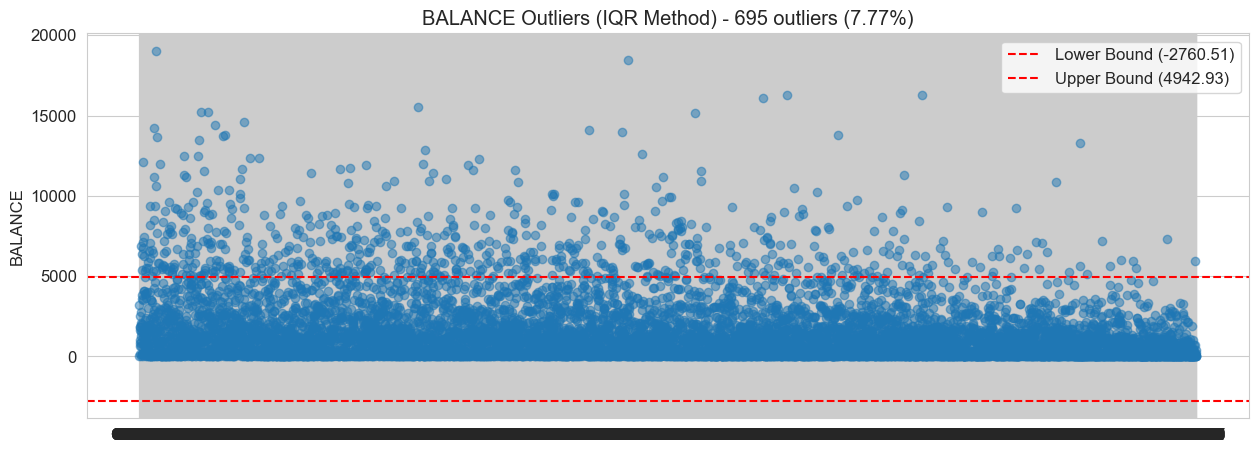

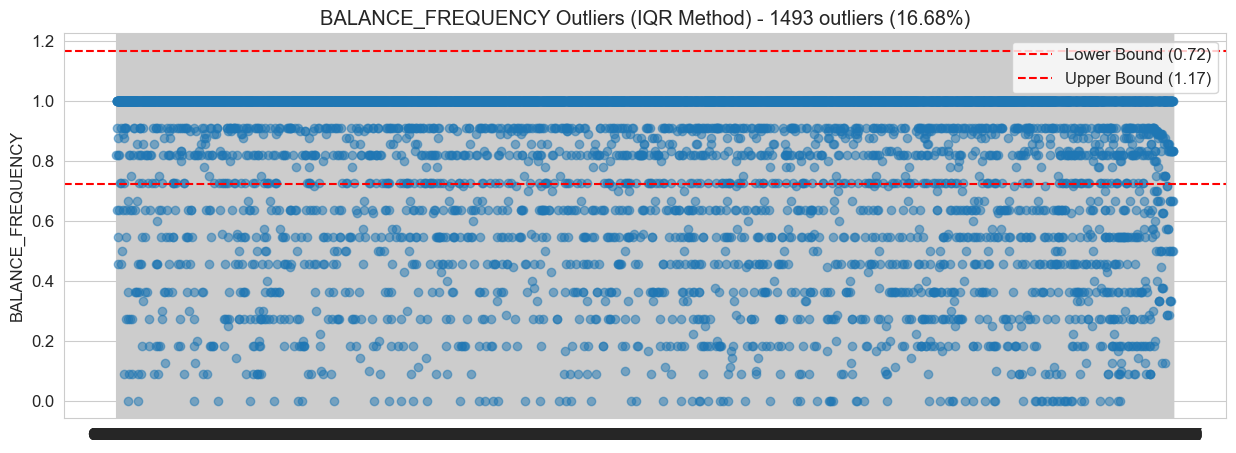

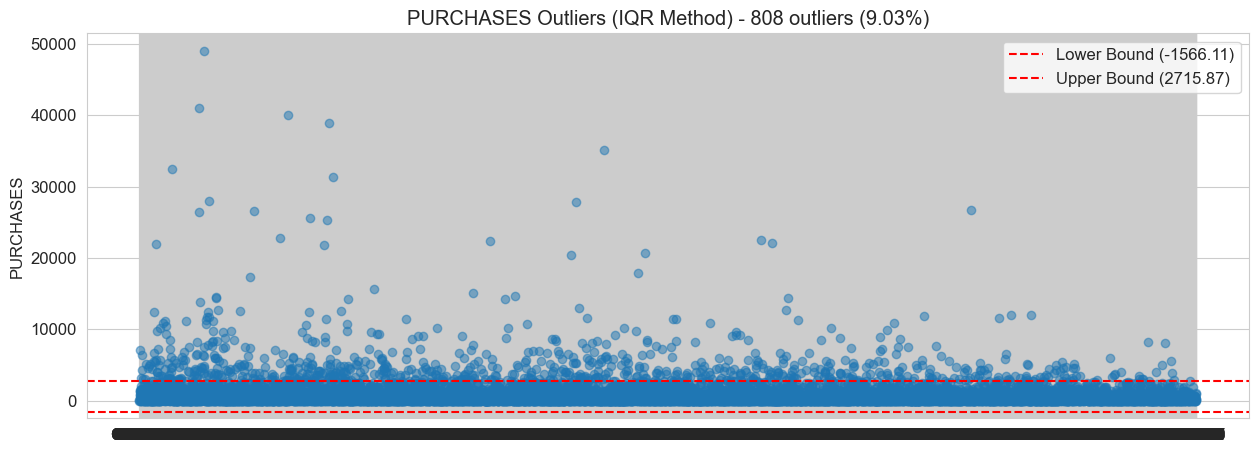

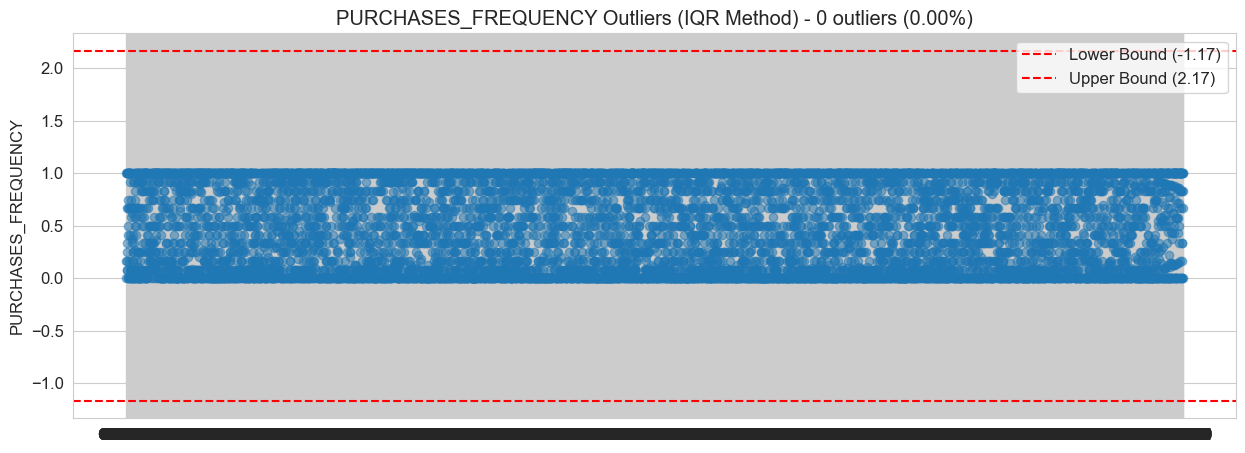

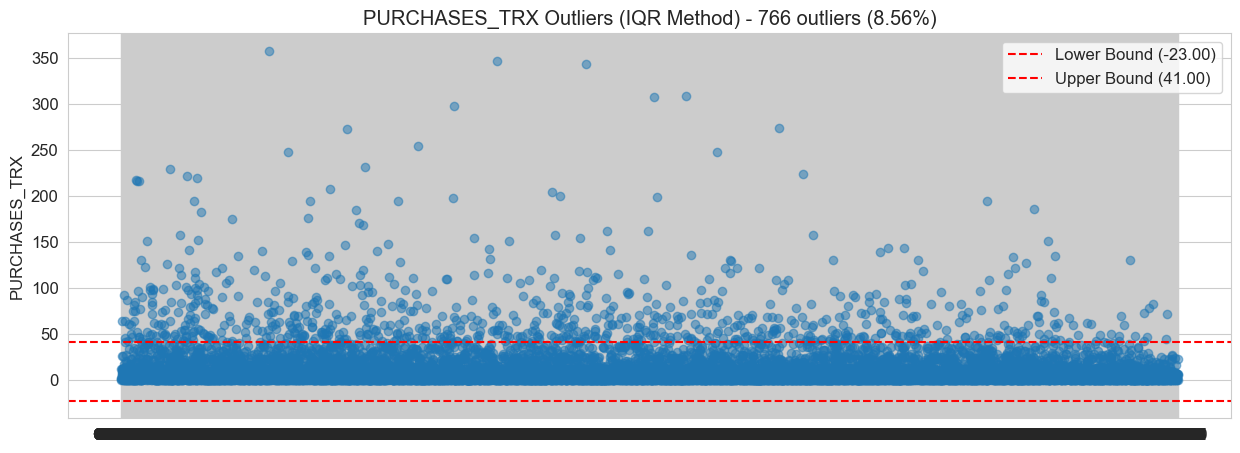


IQR 방법 이상치 요약 (카드 데이터):
                     outlier_count  outlier_percent  lower_bound  upper_bound
BALANCE                        695         7.765363 -2760.505265  4942.927215
BALANCE_FREQUENCY             1493        16.681564     0.722223     1.166666
PURCHASES                      808         9.027933 -1566.107500  2715.872500
PURCHASES_FREQUENCY              0         0.000000    -1.166668     2.166668
PURCHASES_TRX                  766         8.558659   -23.000000    41.000000


In [9]:
# IQR(사분위 범위) 방법으로 이상치 탐지 함수 정의 (재사용)
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers, lower_bound, upper_bound

# 각 수치형 변수에 대해 IQR 이상치 탐지 및 시각화 (개별 저장)
card_outlier_stats = {}
for i, col in enumerate(card_numerical_cols):
    fig = plt.figure(figsize=(15, 5))
    outliers, lower_bound, upper_bound = detect_outliers_iqr(card_data, col)
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(card_data)) * 100
    
    card_outlier_stats[col] = {
        'outlier_count': outlier_count,
        'outlier_percent': outlier_percent,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    
    plt.scatter(card_data.index, card_data[col], alpha=0.5)
    plt.axhline(y=lower_bound, color='r', linestyle='--', label=f'Lower Bound ({lower_bound:.2f})')
    plt.axhline(y=upper_bound, color='r', linestyle='--', label=f'Upper Bound ({upper_bound:.2f})')
    plt.title(f'{col} Outliers (IQR Method) - {outlier_count} outliers ({outlier_percent:.2f}%)')
    plt.ylabel(col)
    plt.legend()
    
    plot_filename = os.path.join(plot_dir_eda2, f'outlier_iqr_{col}.png')
    plt.savefig(plot_filename)
    plt.show()
    plt.close(fig)

# 이상치 통계 출력
card_outlier_summary = pd.DataFrame.from_dict(card_outlier_stats, orient='index')
print("\nIQR 방법 이상치 요약 (카드 데이터):")
print(card_outlier_summary)

### 4.2 머신러닝 기반 이상치 탐지 (IsolationForest)


IsolationForest로 탐지한 이상치 (카드 데이터): 448개 (5.01%)


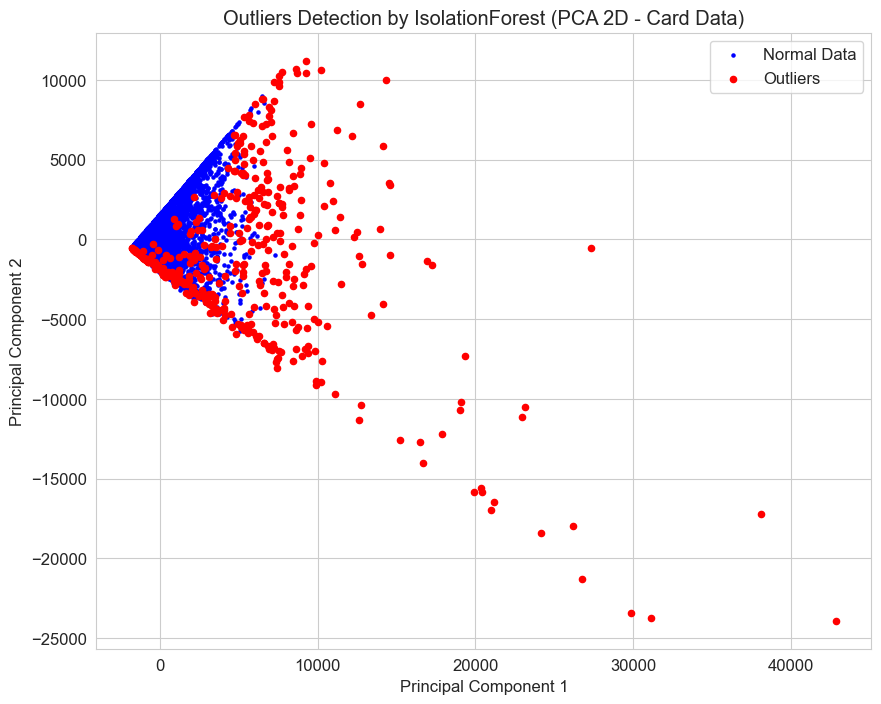

In [10]:
# IsolationForest 이상치 탐지 함수 정의 (재사용)
def detect_outliers_iforest(df, cols, contamination=0.05):
    X = df[cols].copy()
    clf = IsolationForest(contamination=contamination, random_state=42)
    y_pred = clf.fit_predict(X)
    return df, y_pred == -1

# 모든 수치형 변수에 대해 IsolationForest 적용
_, card_is_outlier_if = detect_outliers_iforest(card_data, card_numerical_cols)

card_outlier_count_if = np.sum(card_is_outlier_if)
card_outlier_percent_if = (card_outlier_count_if / len(card_data)) * 100
print(f"\nIsolationForest로 탐지한 이상치 (카드 데이터): {card_outlier_count_if}개 ({card_outlier_percent_if:.2f}%)")

# 시각화를 위해 PCA로 차원 축소 (2D)
card_pca_2d = PCA(n_components=2)
card_X_pca_2d = card_pca_2d.fit_transform(card_data)

# 이상치 시각화 (2D PCA)
fig_if_2d = plt.figure(figsize=(10, 8))
plt.scatter(card_X_pca_2d[~card_is_outlier_if, 0], card_X_pca_2d[~card_is_outlier_if, 1], c='blue', s=5, label='Normal Data')
plt.scatter(card_X_pca_2d[card_is_outlier_if, 0], card_X_pca_2d[card_is_outlier_if, 1], c='red', s=20, label='Outliers')
plt.title('Outliers Detection by IsolationForest (PCA 2D - Card Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plot_filename_if_2d = os.path.join(plot_dir_eda2, 'outlier_iforest_pca_2d.png')
plt.savefig(plot_filename_if_2d)
plt.show()
plt.close(fig_if_2d)

### 4.3 이상치 처리 (예시)
- 클러스터링 알고리즘은 이상치에 민감할 수 있으므로, 처리 방법을 고려해야 합니다.
- 여기서는 IQR 기반 클리핑을 예시로 적용하지만, 실제 모델링 시에는 제거, 다른 대체 방법 등을 실험해볼 수 있습니다.

In [11]:
# IQR 기반 클리핑 함수 정의 (재사용)
def clip_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower_bound, upper_bound)

# 이상치 처리 (클리핑)
card_clipped = card_data.copy()
for col in card_numerical_cols:
    card_clipped[col] = clip_outliers_iqr(card_clipped[col])

print("\n이상치 클리핑 후 데이터 통계 요약 (카드 데이터):")
print(card_clipped.describe())


이상치 클리핑 후 데이터 통계 요약 (카드 데이터):
           BALANCE  BALANCE_FREQUENCY    PURCHASES  PURCHASES_FREQUENCY  \
count  8950.000000        8950.000000  8950.000000          8950.000000   
mean   1390.508973           0.931587   737.149330             0.490351   
std    1537.538479           0.110984   879.534788             0.401371   
min       0.000000           0.722223     0.000000             0.000000   
25%     128.281915           0.888889    39.635000             0.083333   
50%     873.385231           1.000000   361.280000             0.500000   
75%    2054.140036           1.000000  1110.130000             0.916667   
max    4942.927215           1.000000  2715.872500             1.000000   

       PURCHASES_TRX  
count    8950.000000  
mean       11.623799  
std        13.041645  
min         0.000000  
25%         1.000000  
50%         7.000000  
75%        17.000000  
max        41.000000  


## 5. 특성 변환

### 5.1 스케일링
- 클러스터링은 거리 기반 알고리즘이 많으므로 스케일링이 필수적입니다.
- 이상치 처리된 데이터를 StandardScaler로 표준화합니다.


StandardScaler 적용 후 데이터 통계 요약 (카드 데이터):
            BALANCE  BALANCE_FREQUENCY     PURCHASES  PURCHASES_FREQUENCY  \
count  8.950000e+03       8.950000e+03  8.950000e+03         8.950000e+03   
mean  -8.891708e-17      -1.244839e-15  1.460781e-16         9.328354e-17   
std    1.000056e+00       1.000056e+00  1.000056e+00         1.000056e+00   
min   -9.044240e-01      -1.886552e+00 -8.381596e-01        -1.221758e+00   
25%   -8.209860e-01      -3.847451e-01 -7.930935e-01        -1.014125e+00   
50%   -3.363510e-01       6.164594e-01 -4.273740e-01         2.404259e-02   
75%    4.316433e-01       6.164594e-01  4.240895e-01         1.062211e+00   
max    2.310587e+00       6.164594e-01  2.249864e+00         1.269843e+00   

       PURCHASES_TRX  
count   8.950000e+03  
mean    5.716098e-17  
std     1.000056e+00  
min    -8.913330e-01  
25%    -8.146512e-01  
50%    -3.545609e-01  
75%     4.122564e-01  
max     2.252618e+00  


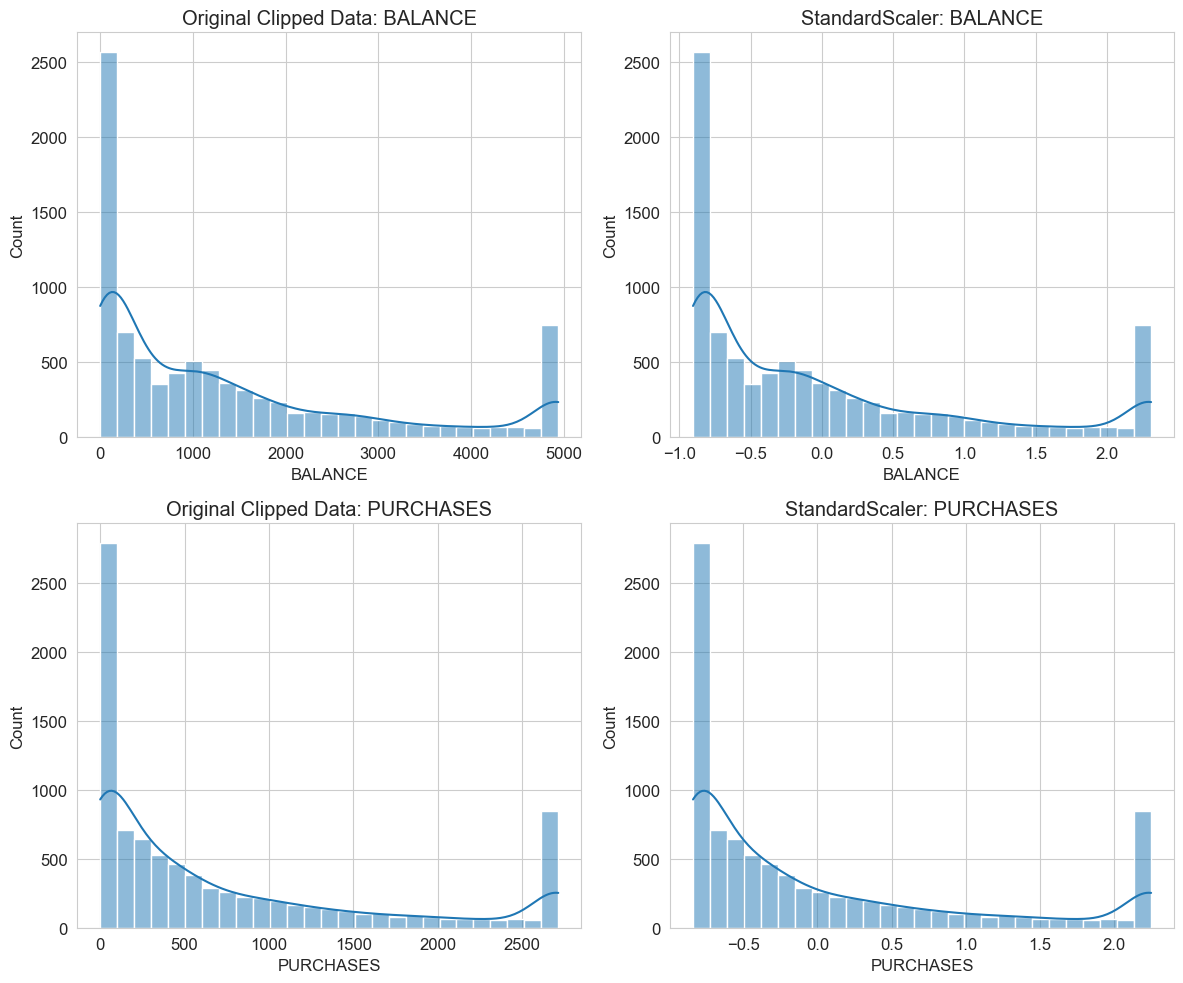

In [12]:
# 이상치 처리된 데이터에 StandardScaler 적용
scaler_card = StandardScaler()
X_card_scaled = scaler_card.fit_transform(card_clipped)
X_card_scaled_df = pd.DataFrame(X_card_scaled, columns=card_numerical_cols, index=card_clipped.index)

print("\nStandardScaler 적용 후 데이터 통계 요약 (카드 데이터):")
print(X_card_scaled_df.describe())

# 변환 결과 시각화 (예: BALANCE, PURCHASES)
fig_scale, axes_scale = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(card_clipped['BALANCE'], kde=True, ax=axes_scale[0, 0])
axes_scale[0, 0].set_title('Original Clipped Data: BALANCE')

sns.histplot(X_card_scaled_df['BALANCE'], kde=True, ax=axes_scale[0, 1])
axes_scale[0, 1].set_title('StandardScaler: BALANCE')

sns.histplot(card_clipped['PURCHASES'], kde=True, ax=axes_scale[1, 0])
axes_scale[1, 0].set_title('Original Clipped Data: PURCHASES')

sns.histplot(X_card_scaled_df['PURCHASES'], kde=True, ax=axes_scale[1, 1])
axes_scale[1, 1].set_title('StandardScaler: PURCHASES')

plt.tight_layout()
plot_filename_scale = os.path.join(plot_dir_eda2, 'scaling_comparison_sample.png')
plt.savefig(plot_filename_scale)
plt.show()
plt.close(fig_scale)

## 6. 상관관계 분석

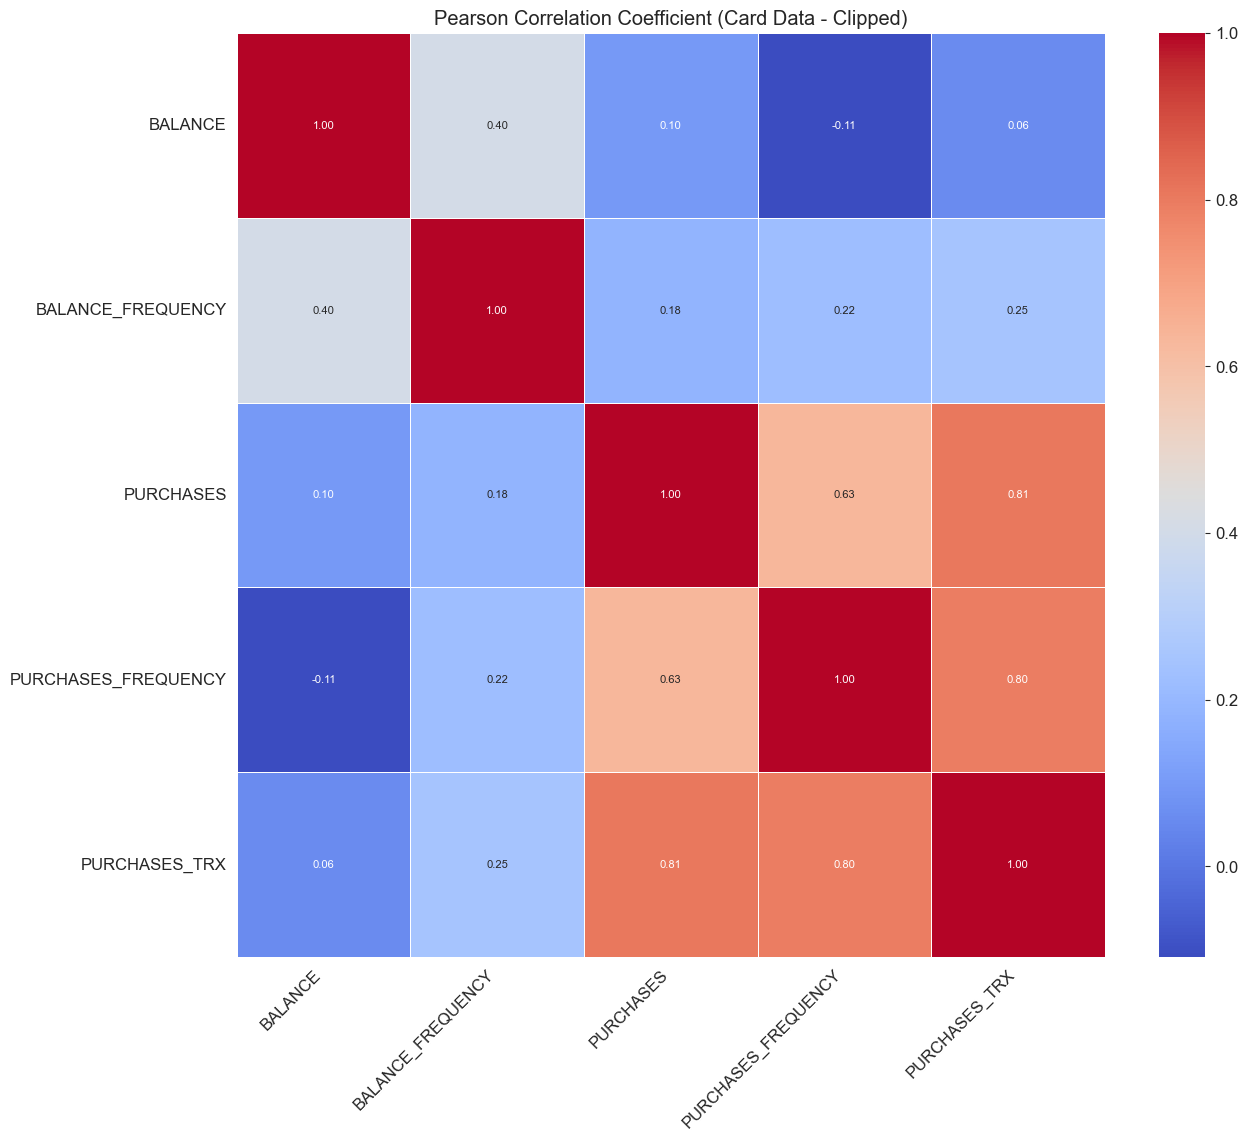

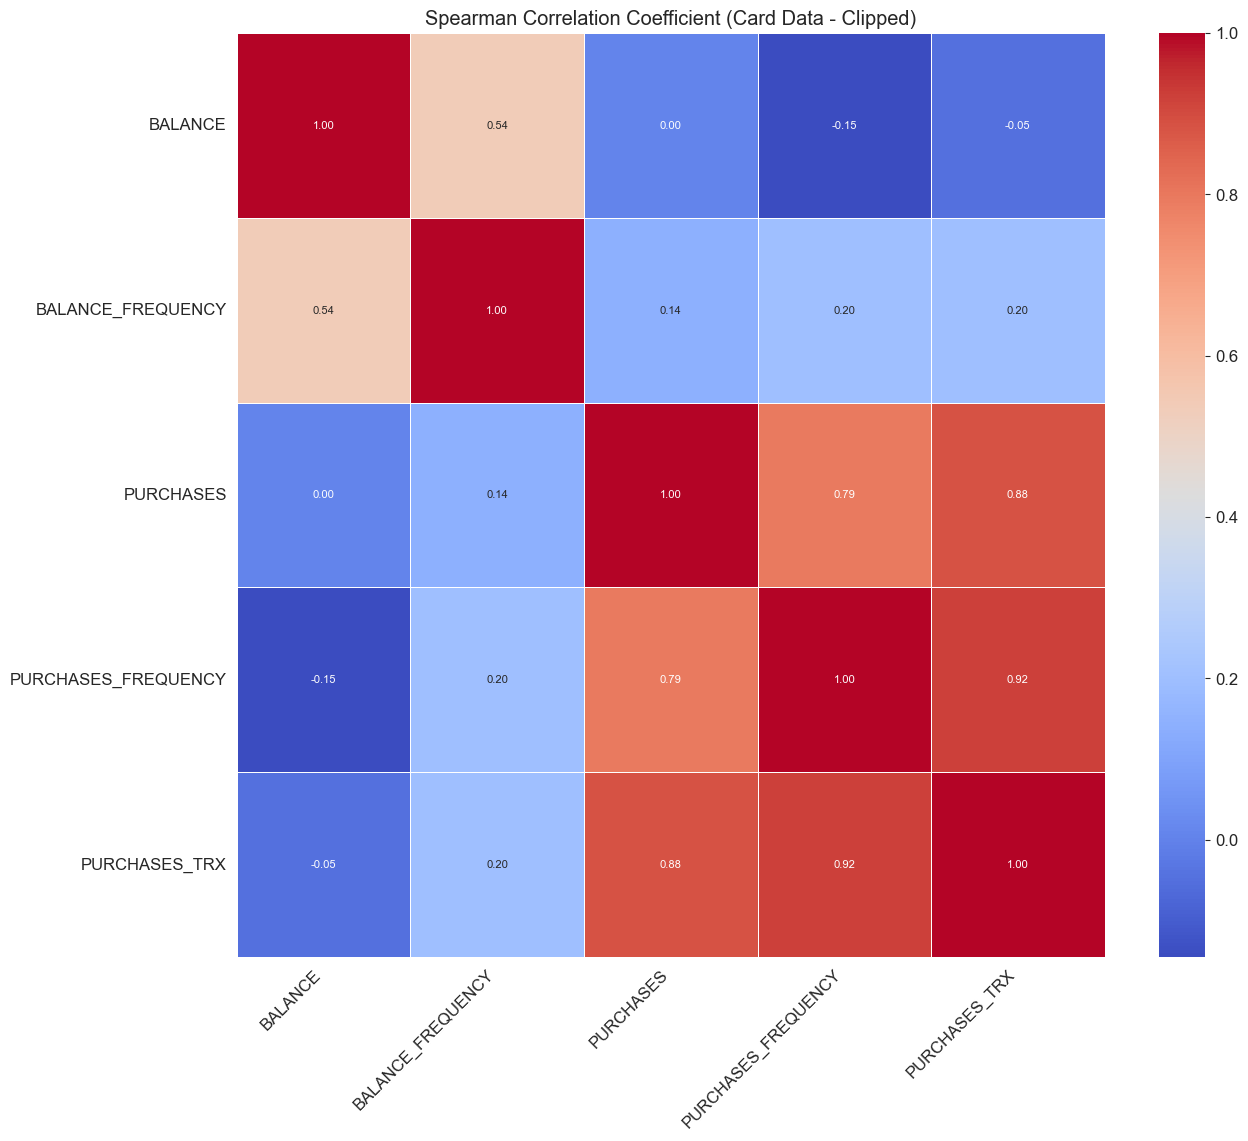

In [13]:
# 피어슨 상관계수 (이상치 처리된 데이터 기준)
card_corr_matrix = card_clipped.corr(method='pearson')

fig_corr_p = plt.figure(figsize=(14, 12))
sns.heatmap(card_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})
plt.title('Pearson Correlation Coefficient (Card Data - Clipped)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plot_filename_corr_p = os.path.join(plot_dir_eda2, 'correlation_pearson.png')
plt.savefig(plot_filename_corr_p)
plt.show()
plt.close(fig_corr_p)

# 스피어만 상관계수 (이상치 처리된 데이터 기준)
card_spearman_corr = card_clipped.corr(method='spearman')

fig_corr_s = plt.figure(figsize=(14, 12))
sns.heatmap(card_spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})
plt.title('Spearman Correlation Coefficient (Card Data - Clipped)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plot_filename_corr_s = os.path.join(plot_dir_eda2, 'correlation_spearman.png')
plt.savefig(plot_filename_corr_s)
plt.show()
plt.close(fig_corr_s)

## 7. 차원 축소

### 7.1 PCA (주성분 분석)
- 스케일링된 데이터를 사용하여 PCA를 수행합니다.

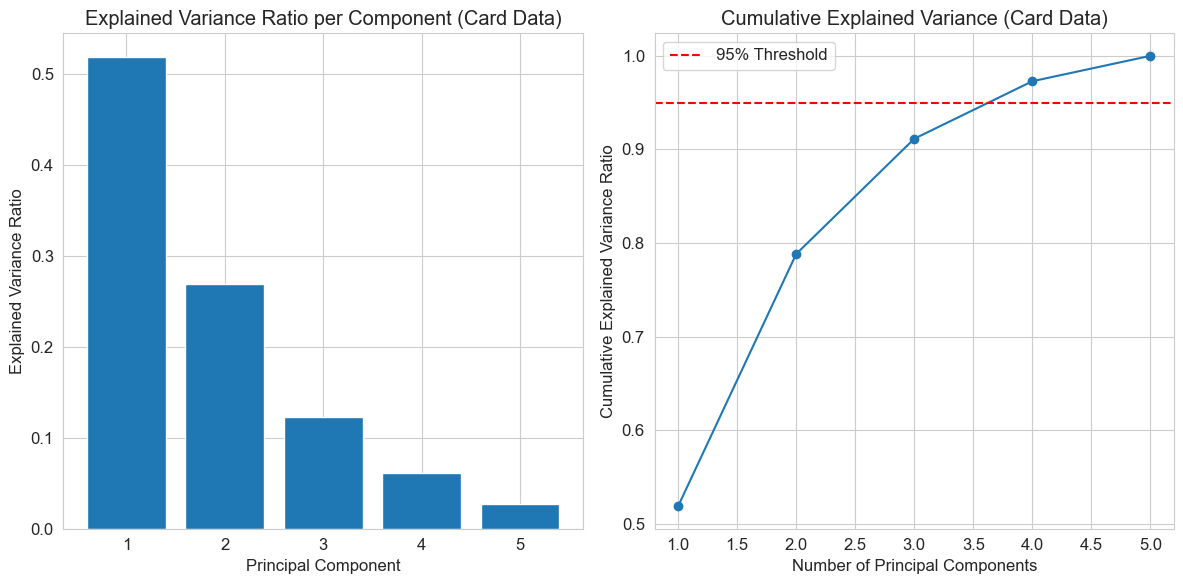

In [14]:
# 스케일링된 데이터에 PCA 수행
card_pca_analysis = PCA()
card_pca_analysis.fit(X_card_scaled_df)

card_explained_variance = card_pca_analysis.explained_variance_ratio_
card_cumulative_variance = np.cumsum(card_explained_variance)

# 결과 시각화 (설명된 분산)
fig_pca_var = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(card_explained_variance)+1), card_explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Component (Card Data)')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(card_cumulative_variance)+1), card_cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance (Card Data)')
plt.legend()

plt.tight_layout()
plot_filename_pca_var = os.path.join(plot_dir_eda2, 'pca_explained_variance.png')
plt.savefig(plot_filename_pca_var)
plt.show()
plt.close(fig_pca_var)

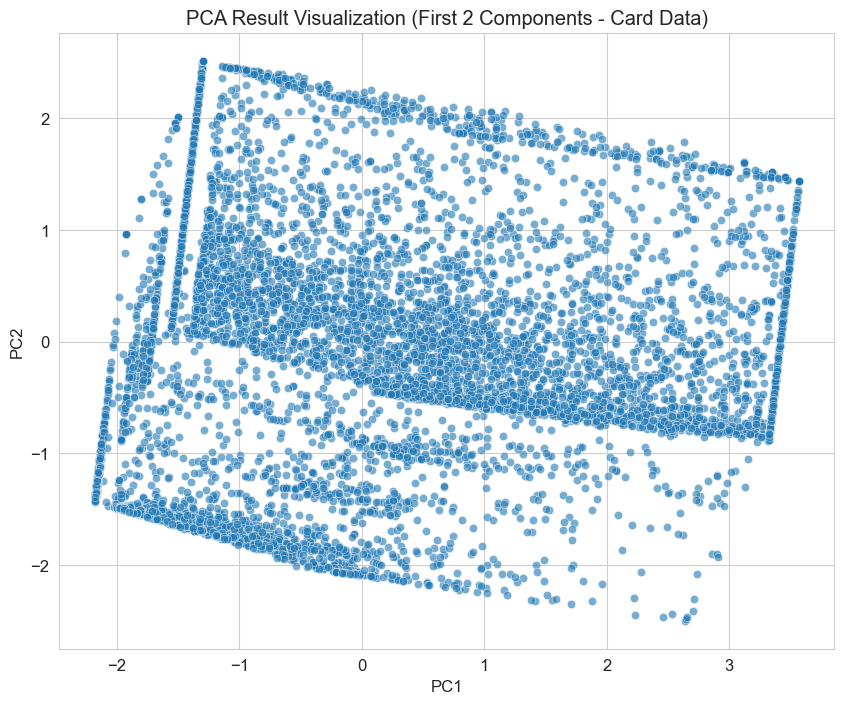

In [15]:
# 처음 2개 주성분으로 시각화 (2D)
card_pca_2d_trans = PCA(n_components=2)
card_X_pca_2d = card_pca_2d_trans.fit_transform(X_card_scaled_df)
card_pca_df_2d = pd.DataFrame(card_X_pca_2d, columns=['PC1', 'PC2'], index=card_clipped.index)

fig_pca_2d = plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=card_pca_df_2d, alpha=0.6)
plt.title('PCA Result Visualization (First 2 Components - Card Data)')
plot_filename_pca_2d = os.path.join(plot_dir_eda2, 'pca_2d_scatter.png')
plt.savefig(plot_filename_pca_2d)
plt.show()
plt.close(fig_pca_2d)

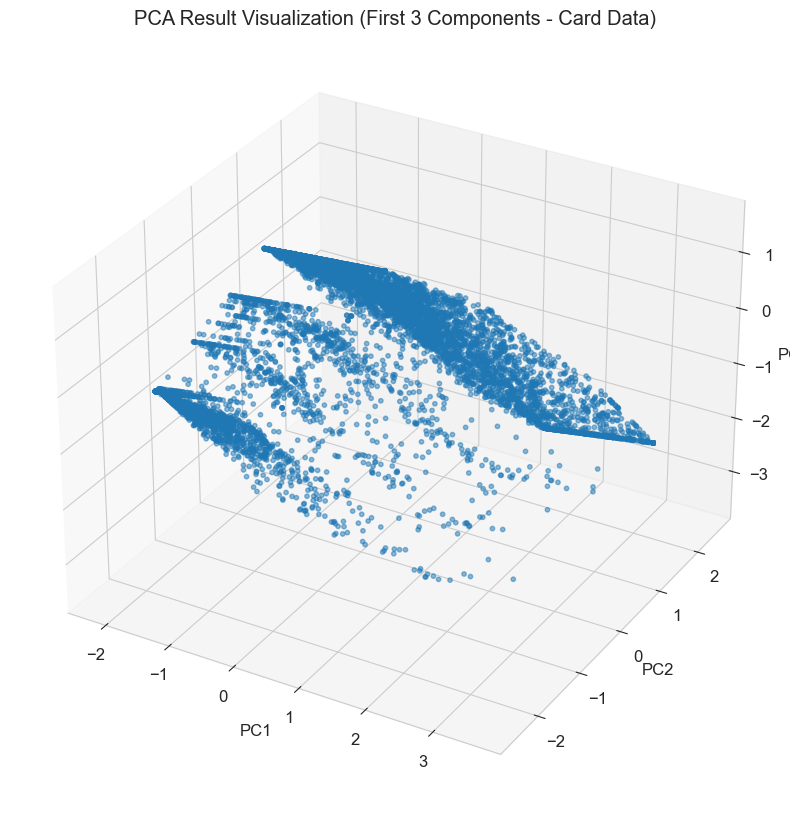

In [16]:
# 처음 3개 주성분으로 시각화 (3D)
card_pca_3d_trans = PCA(n_components=3)
card_X_pca_3d = card_pca_3d_trans.fit_transform(X_card_scaled_df)
card_pca_df_3d = pd.DataFrame(card_X_pca_3d, columns=['PC1', 'PC2', 'PC3'], index=card_clipped.index)

fig_pca_3d = plt.figure(figsize=(12, 10))
ax_pca_3d = fig_pca_3d.add_subplot(111, projection='3d')
ax_pca_3d.scatter(card_pca_df_3d['PC1'], card_pca_df_3d['PC2'], card_pca_df_3d['PC3'], alpha=0.5, s=10)
ax_pca_3d.set_title('PCA Result Visualization (First 3 Components - Card Data)')
ax_pca_3d.set_xlabel('PC1')
ax_pca_3d.set_ylabel('PC2')
ax_pca_3d.set_zlabel('PC3')
plot_filename_pca_3d = os.path.join(plot_dir_eda2, 'pca_3d_scatter.png')
plt.savefig(plot_filename_pca_3d)
plt.show()
plt.close(fig_pca_3d)

### 7.2 t-SNE
- 스케일링된 데이터를 사용하여 t-SNE를 수행합니다.
- 데이터 크기가 크므로 샘플링하여 시각화합니다.


Applying t-SNE to 5000 samples...


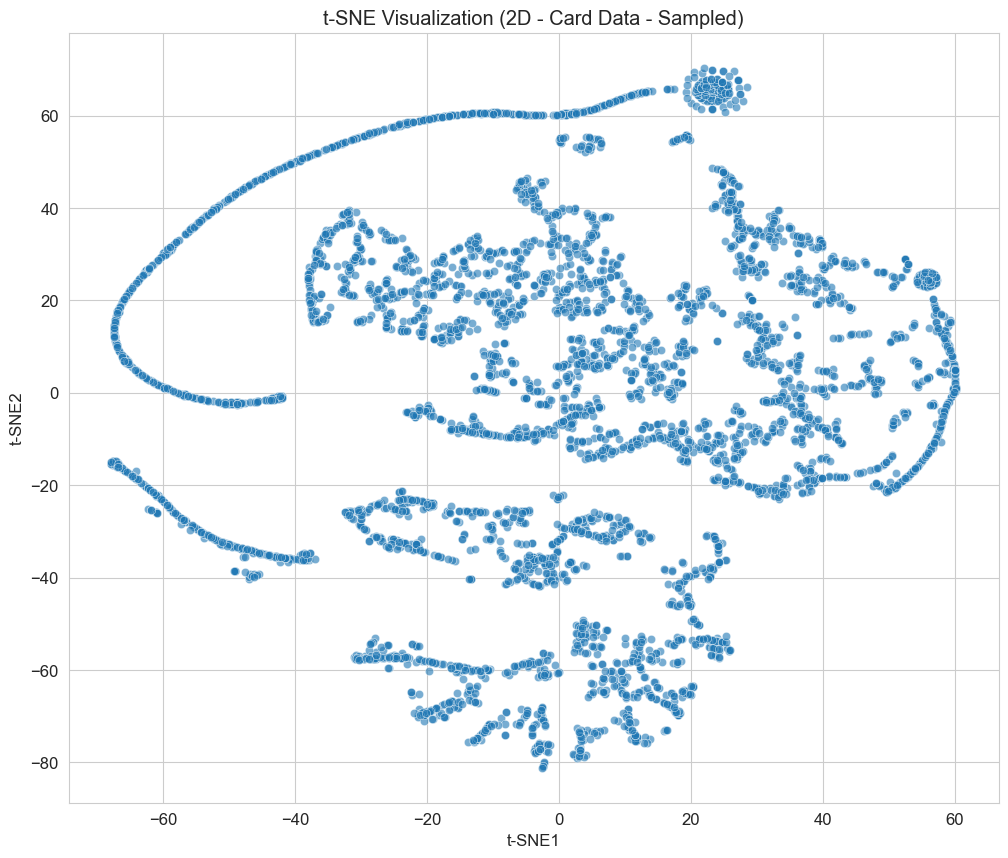

In [17]:
# 샘플링
sample_size = min(5000, len(X_card_scaled_df))
card_tsne_sample_indices = np.random.choice(X_card_scaled_df.index, sample_size, replace=False)
card_tsne_data = X_card_scaled_df.loc[card_tsne_sample_indices]
print(f"\nApplying t-SNE to {sample_size} samples...")

# t-SNE 2D 수행
tsne_card_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_card_tsne_2d = tsne_card_2d.fit_transform(card_tsne_data)

# 결과 시각화 (2D)
tsne_card_df_2d = pd.DataFrame(X_card_tsne_2d, columns=['t-SNE1', 't-SNE2'], index=card_tsne_sample_indices)
fig_tsne_2d = plt.figure(figsize=(12, 10))
sns.scatterplot(x='t-SNE1', y='t-SNE2', data=tsne_card_df_2d, alpha=0.6)
plt.title('t-SNE Visualization (2D - Card Data - Sampled)')
plot_filename_tsne_2d = os.path.join(plot_dir_eda2, 'tsne_2d_scatter.png')
plt.savefig(plot_filename_tsne_2d)
plt.show()
plt.close(fig_tsne_2d)


Applying 3D t-SNE to 5000 samples...


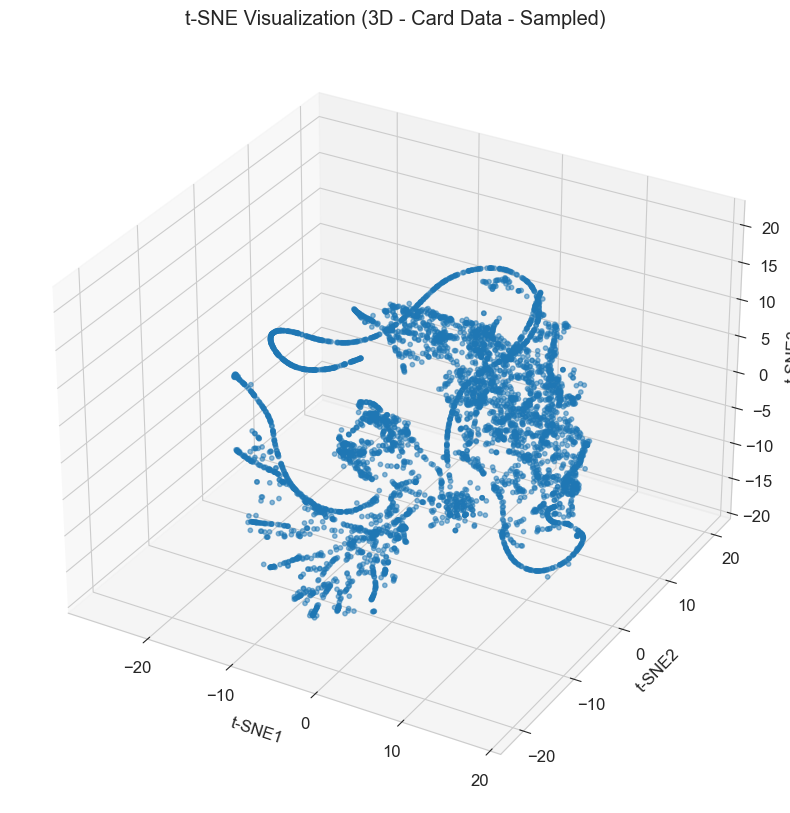

In [18]:
# t-SNE 3D 수행
print(f"\nApplying 3D t-SNE to {sample_size} samples...")
tsne_card_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
X_card_tsne_3d = tsne_card_3d.fit_transform(card_tsne_data)

# 결과 시각화 (3D)
tsne_card_df_3d = pd.DataFrame(X_card_tsne_3d, columns=['t-SNE1', 't-SNE2', 't-SNE3'], index=card_tsne_sample_indices)
fig_tsne_3d = plt.figure(figsize=(12, 10))
ax_tsne_3d = fig_tsne_3d.add_subplot(111, projection='3d')
ax_tsne_3d.scatter(tsne_card_df_3d['t-SNE1'], tsne_card_df_3d['t-SNE2'], tsne_card_df_3d['t-SNE3'], alpha=0.5, s=10)
ax_tsne_3d.set_title('t-SNE Visualization (3D - Card Data - Sampled)')
ax_tsne_3d.set_xlabel('t-SNE1')
ax_tsne_3d.set_ylabel('t-SNE2')
ax_tsne_3d.set_zlabel('t-SNE3')
plot_filename_tsne_3d = os.path.join(plot_dir_eda2, 'tsne_3d_scatter.png')
plt.savefig(plot_filename_tsne_3d)
plt.show()
plt.close(fig_tsne_3d)

## 8. 군집화 분석 (예비)
- 실제 과제에서는 K-Means와 DBSCAN을 적용하고 비교/분석해야 하지만, EDA 단계에서는 데이터의 잠재적 그룹 구조를 파악하기 위해 간단히 수행합니다.
- 스케일링된 데이터(`X_card_scaled_df`)를 사용합니다.

### 8.1 K-Means (예비)

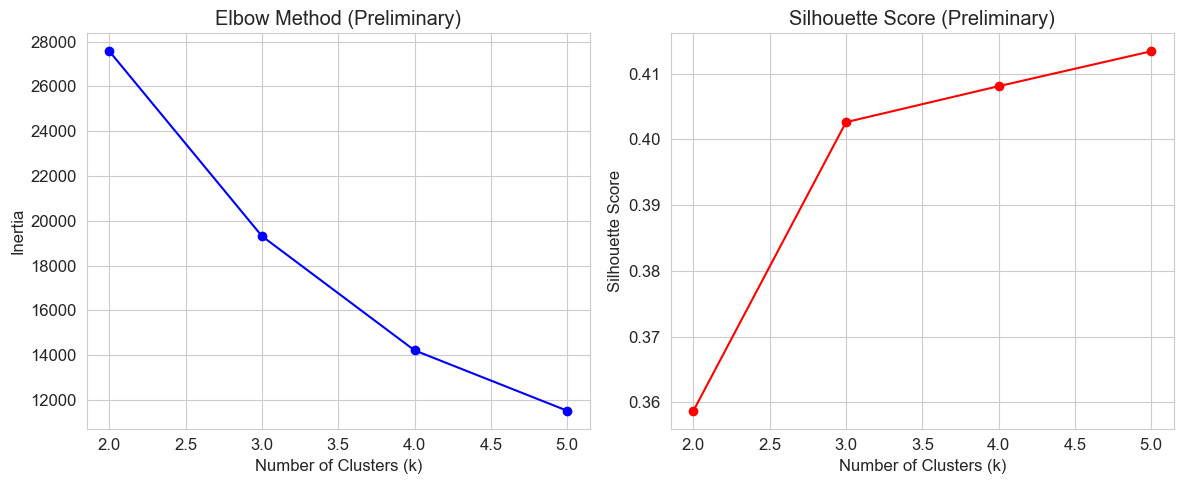

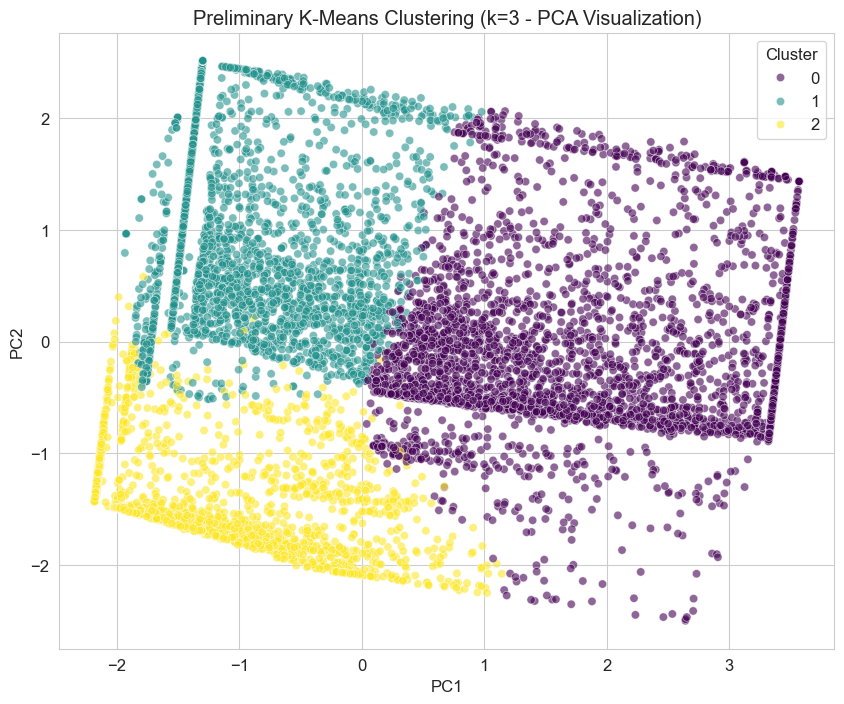

In [19]:
# 최적의 군집 수 탐색 (EDA에서는 2~5개 정도만 확인)
prelim_k_range = range(2, 6)
prelim_inertia = []
prelim_silhouette = []

for k in prelim_k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_card_scaled_df)
    prelim_inertia.append(kmeans.inertia_)
    prelim_silhouette.append(silhouette_score(X_card_scaled_df, kmeans_labels))

fig_kmeans_prelim_k, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(prelim_k_range, prelim_inertia, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method (Preliminary)')

axes[1].plot(prelim_k_range, prelim_silhouette, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score (Preliminary)')

plt.tight_layout()
plot_filename_kmeans_prelim_k = os.path.join(plot_dir_eda2, 'kmeans_preliminary_k.png')
plt.savefig(plot_filename_kmeans_prelim_k)
plt.show()
plt.close(fig_kmeans_prelim_k)

# 예시: k=3으로 군집화 후 시각화 (PCA 2D 활용)
prelim_k = 3 # 위 그래프들을 참고하여 잠정적 k 결정
kmeans_prelim = KMeans(n_clusters=prelim_k, random_state=42, n_init=10)
prelim_kmeans_labels = kmeans_prelim.fit_predict(X_card_scaled_df)

# PCA 결과에 K-Means 레이블 추가 (시각화용)
card_pca_df_2d['prelim_kmeans'] = prelim_kmeans_labels

fig_kmeans_prelim_pca = plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='prelim_kmeans', palette='viridis', data=card_pca_df_2d, alpha=0.6)
plt.title(f'Preliminary K-Means Clustering (k={prelim_k} - PCA Visualization)')
plt.legend(title='Cluster')
plot_filename_kmeans_prelim_pca = os.path.join(plot_dir_eda2, f'kmeans_preliminary_pca_k{prelim_k}.png')
plt.savefig(plot_filename_kmeans_prelim_pca)
plt.show()
plt.close(fig_kmeans_prelim_pca)

### 8.2 DBSCAN (예비)

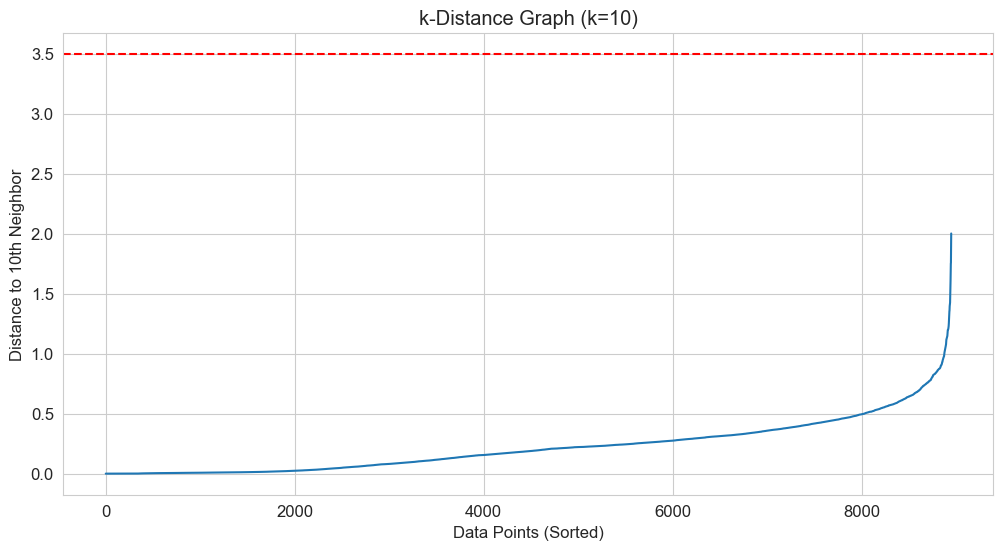

Preliminary DBSCAN (eps=3.5, min_samples=10): 1 clusters, 0 noise points


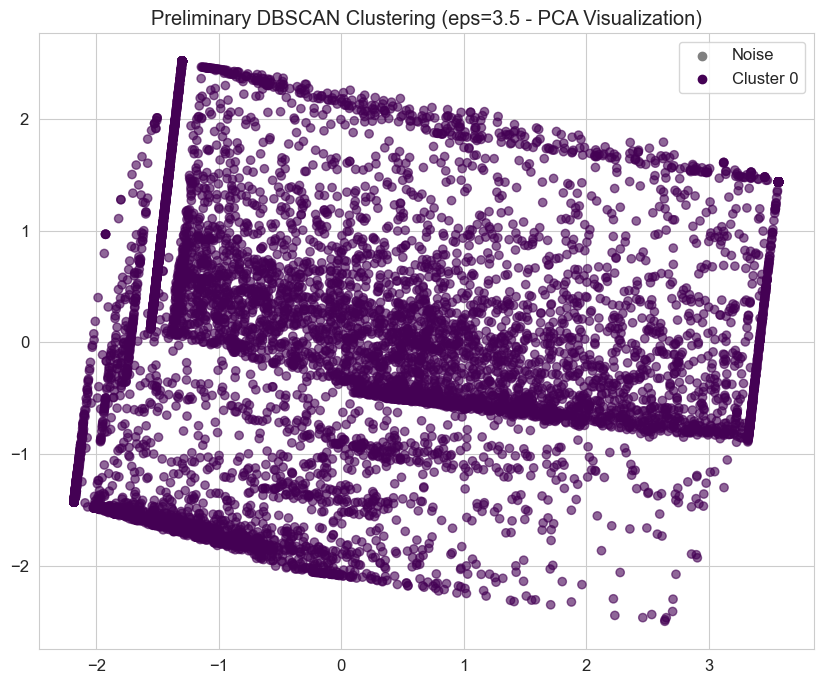

In [20]:
# k-거리 그래프를 통한 eps 파라미터 결정 (재사용 또는 정교화)
neighbors = NearestNeighbors(n_neighbors=10) # min_samples와 유사하게 설정
neighbors_fit = neighbors.fit(X_card_scaled_df)
distances, indices = neighbors_fit.kneighbors(X_card_scaled_df)
distances_k = np.sort(distances[:, -1])

fig_dbscan_prelim_kdist = plt.figure(figsize=(12, 6))
plt.plot(distances_k)
plt.axhline(y=3.5, color='r', linestyle='--') # 이전 EDA 또는 실험값 참고/수정
plt.title('k-Distance Graph (k=10)')
plt.xlabel('Data Points (Sorted)')
plt.ylabel('Distance to 10th Neighbor')
plt.grid(True)
plot_filename_dbscan_prelim_kdist = os.path.join(plot_dir_eda2, 'dbscan_preliminary_k_distance.png')
plt.savefig(plot_filename_dbscan_prelim_kdist)
plt.show()
plt.close(fig_dbscan_prelim_kdist)

# 예시: eps 값 조정하여 DBSCAN 수행
eps_prelim = 3.5 # 위 그래프의 elbow 지점을 참고하여 조정
minsamples_prelim = 10 # k 값과 유사하게 설정

dbscan_prelim = DBSCAN(eps=eps_prelim, min_samples=minsamples_prelim)
dbscan_prelim_labels = dbscan_prelim.fit_predict(X_card_scaled_df)

n_clusters_prelim = len(set(dbscan_prelim_labels)) - (1 if -1 in dbscan_prelim_labels else 0)
n_noise_prelim = list(dbscan_prelim_labels).count(-1)
print(f"Preliminary DBSCAN (eps={eps_prelim}, min_samples={minsamples_prelim}): {n_clusters_prelim} clusters, {n_noise_prelim} noise points")

# PCA 결과에 DBSCAN 레이블 추가 (시각화용)
card_pca_df_2d['prelim_dbscan'] = dbscan_prelim_labels

fig_dbscan_prelim_pca = plt.figure(figsize=(10, 8))
colors = np.array(['gray' if label == -1 else plt.cm.viridis((label % max(1,n_clusters_prelim)) / max(1,n_clusters_prelim)) for label in dbscan_prelim_labels])
plt.scatter(card_pca_df_2d['PC1'], card_pca_df_2d['PC2'], c=colors, alpha=0.6)
plt.title(f'Preliminary DBSCAN Clustering (eps={eps_prelim} - PCA Visualization)')

# 레전드 핸들 추가
noise_handle = plt.scatter([], [], c='gray', label='Noise')
cluster_handles = [plt.scatter([], [], c=plt.cm.viridis(i / max(1,n_clusters_prelim)), label=f'Cluster {i}') for i in range(n_clusters_prelim)]
plt.legend(handles=[noise_handle] + cluster_handles)
plot_filename_dbscan_prelim_pca = os.path.join(plot_dir_eda2, f'dbscan_preliminary_pca_eps{eps_prelim}.png')
plt.savefig(plot_filename_dbscan_prelim_pca)
plt.show()
plt.close(fig_dbscan_prelim_pca)

## 9. 결론 및 인사이트 (prob2_card.csv)

In [21]:
# 데이터셋 요약
print("\n--- Card Data EDA Summary ---")
print(f"데이터셋 크기: {card_data.shape[0]}행 × {card_data.shape[1]}열")
print(f"모든 변수는 수치형: {len(card_numerical_cols)}개")
print(f"결측치 없음 (CUST_ID 제외)")


--- Card Data EDA Summary ---
데이터셋 크기: 8950행 × 5열
모든 변수는 수치형: 5개
결측치 없음 (CUST_ID 제외)


### 9.1 주요 발견 사항 및 인사이트

1. **데이터 분포 및 결측치**
   - 데이터셋에는 결측치가 없어 전처리가 용이합니다.
   - 대부분의 변수들(`BALANCE`, `PURCHASES` 등)이 오른쪽으로 크게 치우친 분포를 보입니다. 이는 소수의 고객이 매우 높은 잔액이나 구매액을 가지고 있음을 의미합니다.
   - `BALANCE_FREQUENCY`와 `PURCHASES_FREQUENCY`는 1에 가까운 값을 가지는 고객이 많아, 잔액과 구매 빈도를 자주 업데이트하는 고객이 많음을 나타냅니다.

2. **이상치 분석**
   - 대부분의 변수에서 IQR 및 머신러닝 기반 탐지 방법 모두에서 다수의 이상치가 발견되었습니다.
   - 특히 `BALANCE`와 `PURCHASES` 관련 변수에서 이상치가 두드러집니다.
   - 클러스터링 성능 향상을 위해 이상치 처리(예: 클리핑)가 필요합니다.

3. **특성 변환**
   - 변수들의 스케일 차이가 크고 분포가 치우쳐 있으므로, 스케일링(StandardScaler)이 필수적입니다.
   - 이상치를 클리핑한 후 스케일링을 적용했습니다.

4. **상관관계 분석**
   - `PURCHASES`는 `PURCHASES_FREQUENCY`, `PURCHASES_TRX`와 강한 양의 상관관계를 보입니다. (구매액이 높을수록 구매 빈도와 거래 횟수도 높음)
   - `BALANCE`는 `BALANCE_FREQUENCY`와 약한 양의 상관관계를 보입니다.

5. **차원 축소 및 군집화 (예비)**
   - PCA 결과, 소수의 주성분으로도 상당 부분의 분산을 설명할 수 있음을 확인했습니다. (예: 6개 주성분으로 90% 이상)
   - t-SNE 시각화 결과, 데이터 내에 명확한 그룹 구조가 있을 가능성을 시사합니다.
   - 예비 K-Means 및 DBSCAN 분석 결과, 데이터가 여러 그룹으로 나뉠 수 있음을 보여줍니다. K-Means는 비교적 균등한 크기의 군집을 형성하는 경향이 있고, DBSCAN은 밀도에 따라 군집을 형성하며 노이즈를 식별합니다. 실제 과제에서는 파라미터 튜닝을 통해 더 적합한 군집 결과를 얻어야 합니다.

6. **클러스터링 과제를 위한 권장사항**
   - **이상치 처리**: 클리핑 또는 다른 이상치 처리 방법을 적용한 후 클러스터링을 수행하는 것이 좋습니다.
   - **스케일링**: StandardScaler를 사용하여 모든 변수를 표준화해야 합니다.
   - **K-Means**: Elbow Method와 Silhouette Score를 사용하여 최적의 k를 신중하게 결정해야 합니다.
   - **DBSCAN**: k-distance plot을 통해 적절한 `eps` 값을 탐색하고, `min_samples` 값도 데이터 특성에 맞게 조정해야 합니다.
   - **모델 비교**: Silhouette Score (DBSCAN의 경우 노이즈 제외) 및 군집의 해석 가능성을 기준으로 모델을 비교하고 선택해야 합니다.
   - **군집 분석**: 선택된 모델의 군집별 평균값(또는 중앙값)을 계산하고, Radar Chart 등을 활용하여 각 군집의 특성을 명확히 설명해야 합니다.
   - **t-SNE 시각화**: 최종 선택된 모델의 군집 레이블을 사용하여 2D 시각화를 수행하고, 군집 분리 정도를 시각적으로 확인해야 합니다.

### 9.2 후속 분석 권장사항

1. **파생 변수 생성**: 
   - `평균 구매 금액 (PURCHASES / PURCHASES_TRX)`
   - `잔액 대비 구매 비율 (PURCHASES / BALANCE)` 등 고객 행동 패턴을 더 잘 나타내는 변수를 생성하여 분석에 활용할 수 있습니다.
2. **다양한 클러스터링 알고리즘**: K-Means, DBSCAN 외에 계층적 군집화(Hierarchical Clustering)나 가우시안 혼합 모델(Gaussian Mixture Models) 등을 적용하여 결과를 비교해볼 수 있습니다.
3. **군집 프로파일링 심화**: 각 군집의 특성을 통계적으로 검증하고(예: ANOVA), 비즈니스 관점에서 의미 있는 고객 세그먼트로 정의합니다.